In [1]:
import networkx as nx
import scipy
import random
import matplotlib.pyplot as plt
import numpy as np
from memory_profiler import memory_usage
import time
from tqdm.notebook import tqdm_notebook as tqdm

NODES = 100
EDGES = 500
MAX_WEIGHT = 50
MIN_WEIGHT = 20

In [2]:
def generate_graph(node_count=NODES, edge_count=EDGES, weight_range=(MIN_WEIGHT, MAX_WEIGHT)):
    g = nx.gnm_random_graph(node_count, edge_count)
    for (u, v, w) in g.edges(data=True):
        w['weight'] = random.randint(weight_range[0], weight_range[1])
    return g

In [3]:
from collections import Mapping, Container
from sys import getsizeof


def deep_getsizeof(o, ids):
    """Find the memory footprint of a Python object

    This is a recursive function that drills down a Python object graph
    like a dictionary holding nested dictionaries with lists of lists
    and tuples and sets.

    The sys.getsizeof function does a shallow size of only. It counts each
    object inside a container as pointer only regardless of how big it
    really is.

    :param o: the object
    :param ids:
    :return:
    """
    d = deep_getsizeof
    if id(o) in ids:
        return 0

    r = getsizeof(o)
    ids.add(id(o))

    if isinstance(o, str):
        return r

    if isinstance(o, Mapping):
        return r + sum(d(k, ids) + d(v, ids) for k, v in o.iteritems())

    if isinstance(o, Container):
        return r + sum(d(x, ids) for x in o)

    return r

C:\Users\Алексей\AppData\Local\Temp\ipykernel_1280\1272591368.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping, Container


# Dinic’s maximum flow algorithm

In [4]:
def test_maximum_flow_algorithm(nodes, edges, algo='dinic'):
    graph = generate_graph(nodes, edges)
    csr_matrix = nx.to_scipy_sparse_array(graph)
    memory = memory_usage(
        (
            scipy.sparse.csgraph.maximum_flow,
            (csr_matrix, 0, 99),
            {'method': algo}
        ),
        max_usage=True
    )
    memory -= deep_getsizeof(csr_matrix, set()) / 1024
    start = time.perf_counter_ns()
    scipy.sparse.csgraph.maximum_flow(csr_matrix, 0, 99, method=algo)
    taken_time = time.perf_counter_ns() - start
    return taken_time, memory

In [5]:
results = []
for e in tqdm(range(1000, 1000000, 5000)):
    taken_time, memory = test_maximum_flow_algorithm(1000, e)
    results.append({
        "time": taken_time,
        "memory": memory,
        "edges": e,
        "nodes": 1000
    })

  0%|          | 0/200 [00:00<?, ?it/s]

In [6]:
results_nodes = []
for n in tqdm(range(1000, 1000000, 5000)):
    taken_time, memory = test_maximum_flow_algorithm(n, 10000)
    results_nodes.append({
        "time": taken_time,
        "memory": memory,
        "edges": 10000,
        "nodes": n
    })

  0%|          | 0/200 [00:00<?, ?it/s]

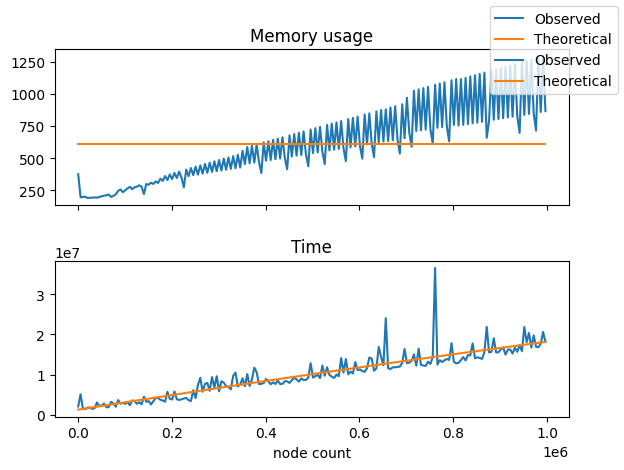

In [7]:
fig, ax = plt.subplots(2, 1, sharex=True)
fig.tight_layout(pad=3.0)

ax[0].set_title("Memory usage")
ax[0].plot(
    [result["nodes"] for result in results_nodes],
    [result["memory"] for result in results_nodes],
    label='Observed'
)
ax[0].plot(
    [result["nodes"] for result in results_nodes],
    np.polyval(
        np.polyfit(
            [result["nodes"] for result in results_nodes],
            [result["memory"] for result in results_nodes],
            deg=0
        ),
        [result["nodes"] for result in results_nodes]
    ),
    label='Theoretical'
)

ax[1].plot(
    [result["nodes"] for result in results_nodes],
    [result["time"] for result in results_nodes],
    label='Observed'
)
ax[1].plot(
    [result["nodes"] for result in results_nodes],
    np.polyval(
        np.polyfit(
            [result["nodes"] for result in results_nodes],
            [result["time"] for result in results_nodes],
            deg=2
        ),
        [result["nodes"] for result in results_nodes]
    ),
    label='Theoretical'
)
ax[1].set_title("Time")
ax[1].set_xlabel("node count")
fig.legend()
plt.savefig("./figures/dinc_algo_by_node.png")
plt.show()

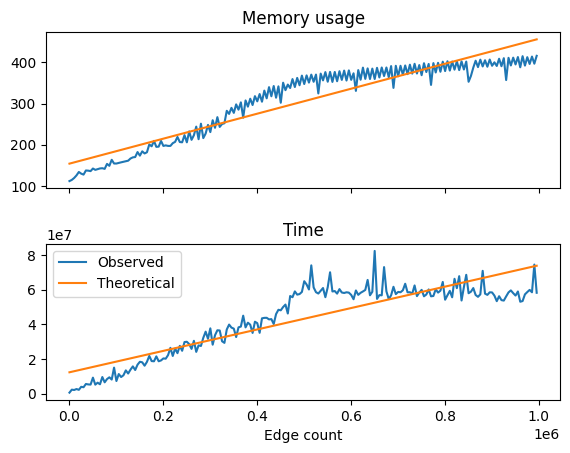

In [8]:
fig, ax = plt.subplots(2, 1, sharex=True)
fig.tight_layout(pad=3.0)

ax[0].set_title("Memory usage")
ax[0].plot(
    [result["edges"] for result in results],
    [result["memory"] for result in results],
    label='Observed'
)
ax[0].plot(
    [result["edges"] for result in results],
    np.polyval(
        np.polyfit(
            [result["edges"] for result in results],
            [result["memory"] for result in results],
            deg=1
        ),
        [result["edges"] for result in results]
    ),
    label='Theoretical'
)
#ax[0].set_xlabel("node count")

ax[1].plot(
    [result["edges"] for result in results],
    [result["time"] for result in results],
    label='Observed'
)
ax[1].plot(
    [result["edges"] for result in results],
    np.polyval(
        np.polyfit(
            [result["edges"] for result in results],
            [result["time"] for result in results],
            deg=1
        ),
        [result["edges"] for result in results]
    ),
    label='Theoretical'
)
ax[1].set_title("Time")
ax[1].set_xlabel("Edge count")
plt.legend()
plt.savefig("./figures/dinc_algo_by_edge.png")
plt.show()

# Edmonds Karp maximum flow algorithm

In [13]:

results_edmonds = []
for e in tqdm(range(1000, 1000000, 5000)):
    taken_time, memory = test_maximum_flow_algorithm(1000, e, algo="edmonds_karp")
    results_edmonds.append({
        "time": taken_time,
        "memory": memory,
        "edges": e,
        "nodes": 1000
    })

  0%|          | 0/200 [00:00<?, ?it/s]

In [14]:
results_nodes_edmonds = []
for n in tqdm(range(1000, 1000000, 5000)):
    taken_time, memory = test_maximum_flow_algorithm(n, 10000, algo='edmonds_karp')
    results_nodes_edmonds.append({
        "time": taken_time,
        "memory": memory,
        "edges": 10000,
        "nodes": n
    })


  0%|          | 0/200 [00:00<?, ?it/s]

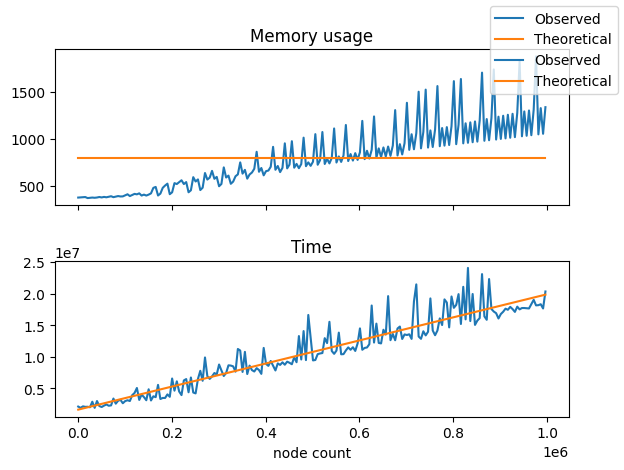

In [15]:
fig, ax = plt.subplots(2, 1, sharex=True)
fig.tight_layout(pad=3.0)

ax[0].set_title("Memory usage")
ax[0].plot(
    [result["nodes"] for result in results_nodes_edmonds],
    [result["memory"] for result in results_nodes_edmonds],
    label='Observed'
)
ax[0].plot(
    [result["nodes"] for result in results_nodes_edmonds],
    np.polyval(
        np.polyfit(
            [result["nodes"] for result in results_nodes_edmonds],
            [result["memory"] for result in results_nodes_edmonds],
            deg=0
        ),
        [result["nodes"] for result in results_nodes_edmonds]
    ),
    label='Theoretical'
)

ax[1].plot(
    [result["nodes"] for result in results_nodes_edmonds],
    [result["time"] for result in results_nodes_edmonds],
    label='Observed'
)
ax[1].plot(
    [result["nodes"] for result in results_nodes_edmonds],
    np.polyval(
        np.polyfit(
            [result["nodes"] for result in results_nodes_edmonds],
            [result["time"] for result in results_nodes_edmonds],
            deg=1
        ),
        [result["nodes"] for result in results_nodes_edmonds]
    ),
    label='Theoretical'
)
ax[1].set_title("Time")
ax[1].set_xlabel("node count")
fig.legend()
plt.savefig("./figures/edmond_algo_by_node.png")
plt.show()

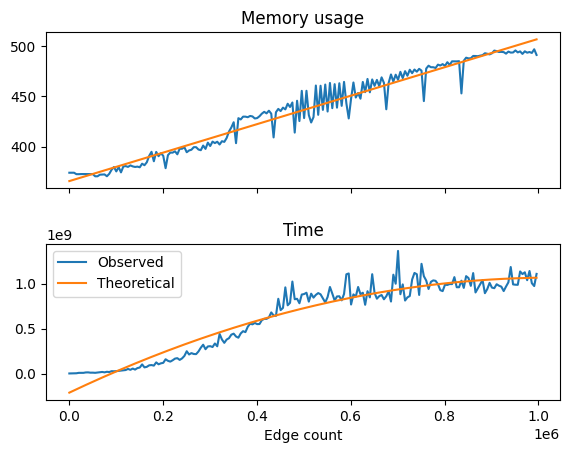

In [17]:
fig, ax = plt.subplots(2, 1, sharex=True)
fig.tight_layout(pad=3.0)

ax[0].set_title("Memory usage")
ax[0].plot(
    [result["edges"] for result in results_edmonds],
    [result["memory"] for result in results_edmonds],
    label='Observed'
)
ax[0].plot(
    [result["edges"] for result in results_edmonds],
    np.polyval(
        np.polyfit(
            [result["edges"] for result in results_edmonds],
            [result["memory"] for result in results_edmonds],
            deg=1
        ),
        [result["edges"] for result in results_edmonds]
    ),
    label='Theoretical'
)
#ax[0].set_xlabel("node count")

ax[1].plot(
    [result["edges"] for result in results_edmonds],
    [result["time"] for result in results_edmonds],
    label='Observed'
)
ax[1].plot(
    [result["edges"] for result in results_edmonds],
    np.polyval(
        np.polyfit(
            [result["edges"] for result in results_edmonds],
            [result["time"] for result in results_edmonds],
            deg=2
        ),
        [result["edges"] for result in results_edmonds]
    ),
    label='Theoretical'
)
ax[1].set_title("Time")
ax[1].set_xlabel("Edge count")
plt.legend()
plt.savefig("./figures/edmond_algo_by_edge.png")
plt.show()